# Problem

How is the trend of home prices at King County look like?

# Abstract:

In this analysis it will be explored the trend of houses' prices at King County in WA

The analysis is is divided the following way:

### Data:
- **Data Cleaning**
    - `Price` Distribution
    - `Price` Time Distribution

### Analysis: Icecream Production in California:
- **STL Decomposition of the Variable**
    - DF Testing
- **Time Series Model**
    - Linear Regression Model
    - ARIMA Model (extra)

### Summary/conclusions:




**Note:**
- *prepare the data via cleaning, normalization, encoding, etc.*
- *generate and evaluate a working time series model.*

In [1]:
#Loading libraries
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy.random as nr
import scipy.stats as ss
import statsmodels.tsa.seasonal as sts
import statsmodels.graphics.tsaplots as splt
import statsmodels.tsa.arima_process as arima
from statsmodels.tsa.stattools import adfuller
import numpy as np

# Data:

In [2]:
#Load File
filename = 'kc_house_data.csv'
house_df = pd.read_csv(filename)

## Data cleaning:

**Since in previous analysis (Milestone 1) it was already presented the *first look to the data* an some reasoning on why the data was filtered in certain way, in this section of the analysis it would be assumed as already covered and understood.**

In [3]:
#Removing outliers based on Price:
LimitHi = np.mean(house_df['price']) + 1*np.std(house_df['price']) #Higher Limit for each of the numeric attributes
LimitLo = np.mean(house_df['price']) - 1*np.std(house_df['price']) #Lower Limit for each of the numeric attributes
FlagBad = (house_df['price'] < LimitLo) | (house_df['price'] > LimitHi) #Boolean for values outside limits
FlagGood = ~FlagBad #Complement
house_df = house_df.loc[FlagGood]

#Some cleaning of the data (outliers) will be removed since we are interested in the typical market for the region.
FlagBad = (house_df['bedrooms'] > 8) #Boolean for values outside limits
FlagGood = ~FlagBad #Complement
house_df = house_df.loc[FlagGood] 

FlagBad = (house_df['bathrooms'] > 6) #Boolean for values outside limits
FlagGood = ~FlagBad #Complement
house_df = house_df.loc[FlagGood] 

FlagBad = (house_df['sqft_lot'] > 50000) #Boolean for values outside limits
FlagGood = ~FlagBad #Complement
house_df = house_df.loc[FlagGood] 

In [4]:
house_df = house_df.dropna()

In [5]:
#Transforming the variable date into DateTime Variable
house_df.loc[:, 'date'] = pd.to_datetime(house_df.loc[:, 'date'])
#house_df.set_index('date', inplace = True)

In [6]:
#Column price from str to numeric (int64)
house_df['price'] = pd.to_numeric(house_df['price'])

#Creating a variable called `price_log`
house_df['price_log'] = np.log(house_df['price'])

#Column price from str to numeric (int64)
house_df['sqft_living'] = pd.to_numeric(house_df['sqft_living'])

#Creating a variable called `price_log`
house_df['sqft_living_log'] = np.log(house_df['sqft_living'])

### `Price` Distribution

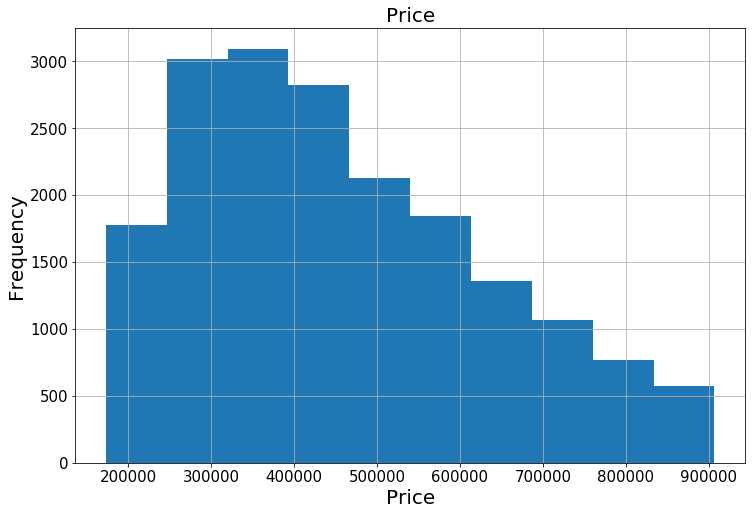

In [7]:
house_df['price'].hist(figsize = (12,8))
plt.xlabel('Price', fontsize = 20)
plt.ylabel('Frequency',fontsize = 20)
plt.title('Price', fontsize = 20)
plt.tick_params(axis="x", labelsize=15)
plt.tick_params(axis="y", labelsize=15)
plt.grid(True)
plt.show()

As it can be seen the avg `price` of a house in this sample is around ~$380,000 (after outliers were removed).

In [8]:
house_df.head(2)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_log,sqft_living_log
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,...,0,1955,0,98178,47.5112,-122.257,1340,5650,12.309982,7.073270
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,...,400,1951,1991,98125,47.7210,-122.319,1690,7639,13.195614,7.851661


In [9]:
house_df.dtypes

id                          int64
date               datetime64[ns]
price                     float64
bedrooms                    int64
bathrooms                 float64
sqft_living                 int64
sqft_lot                    int64
floors                    float64
waterfront                  int64
view                        int64
condition                   int64
grade                       int64
sqft_above                  int64
sqft_basement               int64
yr_built                    int64
yr_renovated                int64
zipcode                     int64
lat                       float64
long                      float64
sqft_living15               int64
sqft_lot15                  int64
price_log                 float64
sqft_living_log           float64
dtype: object

In [10]:
#house_df = house_df.sort_index(inplace=True)

In [11]:
house_df.index = house_df['date']

## `Price` Time Distribution

In [12]:
def plot_ts(ts, lab = ''):
    plt.figure(figsize=(10, 4)).gca()
    ts.plot()
    plt.title('Time series plot of ' + lab, fontsize = 20)
    plt.ylabel('Value', fontsize = 15)
    plt.xlabel('Date', fontsize = 15)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)           
    plt.grid(True)

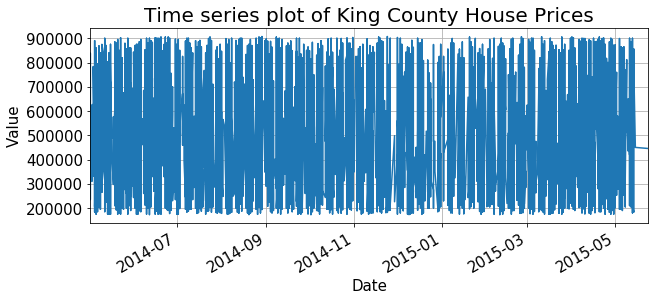

In [13]:
plot_ts(house_df['price'], 'King County House Prices')

In [14]:
house_df.shape

(18459, 23)

As it is possible to see from the plot above (and the number of data) it is hard to see any trend of significant behavior by looking at the data (after outliers are being removed). Therefore and with the goal of showing any significant information the data will be grouped by week.

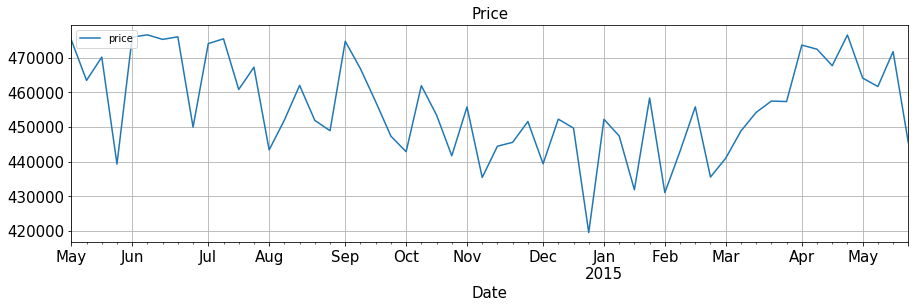

In [15]:
#Time series plot for Price
#To minimize the noise each data point seen here is the mean of a 2 Weeks sample
house_df[["price"]].resample("1W").mean().plot(figsize=(15,4))
plt.tick_params(axis="x", labelsize=15)
plt.tick_params(axis="y", labelsize=15)
plt.xlabel('Date', fontsize = 15)
plt.title('Price',fontsize=15)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True)

After grouping the data by week it is possible to notice some trends and characteristics of the data.

In [16]:
house_df.sort_index(inplace= True)

# Analysis:

## STL Decomposition of the Variable

As mentioned above since the data it is just one year (from 2014 to 2015) and we have multiple entries per day, the data was grouped by week.

In [17]:
#def decomp_ts(ts, freq = 'M', model = 'additive'):
def decomp_ts(ts, period, model = 'additive'):
    res = sts.seasonal_decompose(ts, model = model, period = period) #, freq = freq)
    res.plot()
    return(pd.DataFrame({'resid': res.resid, 
                         'trend': res.trend, 
                         'seasonal': res.seasonal},
                       index = ts.index) )

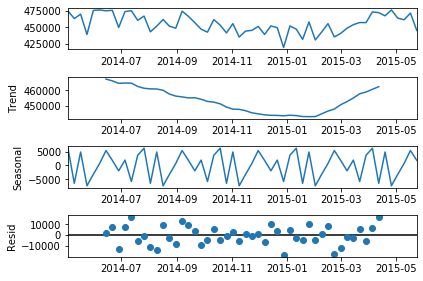

In [18]:
price_decom = decomp_ts(house_df[["price"]].resample("1W").mean(), period = 12)

From the STL Decomposition it is possible to notice:
- There is a trend where around the beginning of the year we see the lowest price.
- Some seasonal effect it is seen, that is likely a small cycle of 1 to 2 weeks where the price changes (and or houses on the market shift from high end to medium end)
- The residual it is larger than the seasonal effect, this is potentially given by the fact that we only have 1 year worth of data for this analysis.
- The **Resid** value seems to be *Noise* as expected, without a strong seasonal or trend signal, which potentially means that the **Resid** is **STATIONARY**.

### DF Testing

In [19]:
def DF_Test(ts):
    stationary = adfuller(ts)
    ## Print the results
    print('D-F statistic = ' + str(stationary[0]))
    print('p-value = ' + str(stationary[1]))
    print('number of lags used = ' + str(stationary[2]))
    print('Critical value at 5% confidence = ' + str(stationary[4]['5%']))
    print('Critical value at 10% confidence = ' + str(stationary[4]['10%']))

DF_Test(price_decom.resid[6:-6])   

D-F statistic = -5.168772080479776
p-value = 1.0178814042569111e-05
number of lags used = 5
Critical value at 5% confidence = -2.941262357486514
Critical value at 10% confidence = -2.6091995013850418


Given the DF statistic and p-value we can reject the null hypothesis that the residual is not stationary. Then the residual will be treated as **STATIONARY**.

In [20]:
house_df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_log,sqft_living_log
date,,,,,,,,,,,,,,,,,,,,,
2014-05-02,3390600010,2014-05-02,365000.0,3,1.00,1090,6435,1.0,0,0,...,0,1955,0,98106,47.5334,-122.365,1340,6435,12.807653,6.993933
2014-05-02,7525000080,2014-05-02,588500.0,3,1.75,2330,14892,1.0,0,0,...,360,1980,0,98074,47.6267,-122.046,2570,14217,13.285332,7.753624
2014-05-02,6403500290,2014-05-02,407500.0,3,2.50,1930,10460,2.0,0,0,...,0,1996,0,98059,47.4938,-122.161,2290,8228,12.917796,7.565275
2014-05-02,2771102144,2014-05-02,385000.0,3,3.25,1320,1327,2.0,0,0,...,280,2008,0,98199,47.6506,-122.383,1440,1263,12.860999,7.185387
2014-05-02,1999700045,2014-05-02,313000.0,3,1.50,1340,7912,1.5,0,0,...,0,1955,0,98133,47.7658,-122.339,1480,7940,12.653958,7.200425


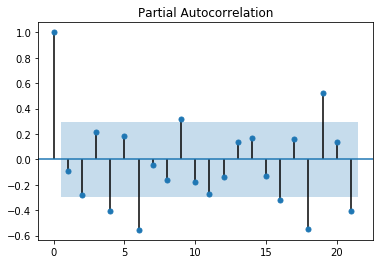

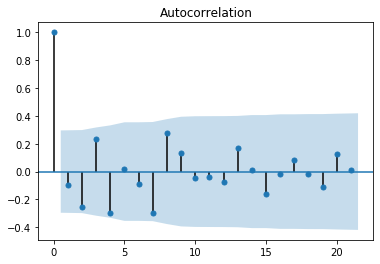

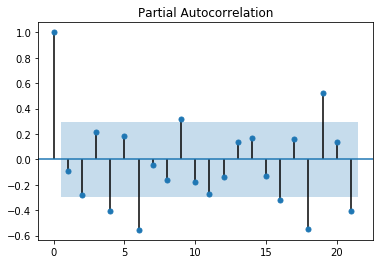

In [21]:
splt.plot_acf(price_decom.resid[6:-6], lags = 21)
splt.plot_pacf(price_decom.resid[6:-6], lags = 21)

It is possible to see that the ACF does not show any significant leg greater than 0, while the PACF shows some significant lags greater than 0 (around 4).

## Time Series Model

In [22]:
house_df['Month'] = house_df['date'].dt.strftime('%b')
##Create dummy variables for the months
unique_years = house_df['date'].dt.strftime('%Y').unique()
dummies = pd.get_dummies(house_df.loc[:, 'Month'])
house_df[list(dummies.columns)] = dummies

In [23]:
house_df['month_year'] = house_df['date'].dt.strftime('%b-%Y')
count = 1
names = house_df['month_year']
listofcounts = [1]
for i in range(len(names)):
    if i == len(names) - 1:
      break
    elif names[i] == names[i+1]:
        listofcounts.append(count)
    else:
        count = count + 1
        listofcounts.append(count)  
house_df['Month_Cnt'] = listofcounts
house_df['Month_Cnt2'] = [x**2 for x in house_df.Month_Cnt]

In [24]:
house_df['Daily'] = house_df[["price"]].resample("1W").mean()
house_df = house_df.dropna()
house_df.loc[:, 'Day_Cnt'] = [float(i + 1) for i in range(len(house_df.price))]
house_df.loc[:, 'Day_Cnt2'] = [x**2 for x in house_df.Day_Cnt]
from scipy.stats import zscore
house_df.loc[:, ['Day_Cnt', 'Day_Cnt2']] = house_df.loc[:, ['Day_Cnt', 'Day_Cnt2']].apply(zscore)

### Linear Regression Model

For simplicity reason a Linear Regression Model was chosen for as the Time Series Model for this analysis as shown below. Different set of inputs were included, but it was decided to keep just the variables noted below as the performance of the model did not increase significantly.

In [25]:
import sklearn.linear_model as lm
#X = house_df.loc[:, ['Month_Cnt','Month_Cnt2','Day_Cnt', 'Day_Cnt2', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']].as_matrix()
X = house_df.loc[:, ['Day_Cnt', 'Day_Cnt2', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']].as_matrix()
Y = house_df.loc[:, 'Daily'].as_matrix()
lm_mod = lm.LinearRegression(fit_intercept = False)
mod_fit = lm_mod.fit(X, Y)

C:\Users\ly266e\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\ly266e\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [26]:
## and the predictions and the residual
house_df.loc[:,'scores'] = mod_fit.predict(X)

In [27]:
house_df.loc[:, 'resids'] = house_df.loc[:, 'scores'] - house_df.loc[:, 'price']

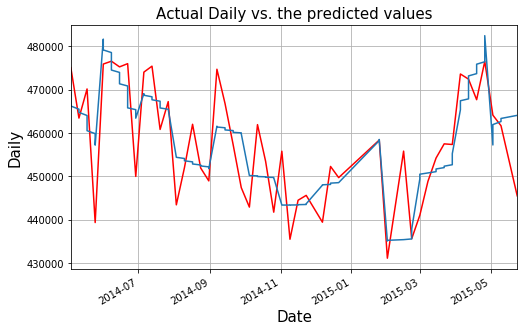

In [28]:
def plot_mod_fit(df, col):
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(8, 5)) # set plot area
    ax = fig.gca() # define axis  
    df.loc[:, col].plot(color = 'r', ax = ax)
    df.loc[:, 'scores'].plot(ax = ax) 
    ax.set_title('Actual ' + col + ' vs. the predicted values', fontsize = 15) # Give the plot a main title
    ax.set_xlabel('Date',fontsize = 15) # Set text for the x axis
    ax.set_ylabel(col,fontsize = 15)# Set text for y axis
    ax.grid(True) 

plot_mod_fit(house_df, 'Daily')   

It is possible to see that the Regression Model follows the general trend of the `price` Time Series, but even though it is a great guideline regarding the behavior of the `price` variable in time, it fails to provide a more meaningful and precise prediction of the data. Also it is possible to see that some over-fitting might be happening as it only represents the data from 1 year (2014 - 2015).

In [29]:
def RMSE(ts, score):
    from math import sqrt
    return sqrt(np.std(ts - score))

## Make the forecast for the next year
#X = house_df.loc['2012-12-01':, ['Month_Cnt', 'Month_Cnt2', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']].as_matrix()
rmse_value = RMSE(house_df.loc[:, 'Daily'].as_matrix(), mod_fit.predict(X))

print('The RMSE Value for the Price regression is '+ str(rmse_value))

The RMSE Value for the Price regression is 84.20962002021399


C:\Users\ly266e\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


In [30]:
Price = house_df['Daily']
Prediction_price = house_df['scores']

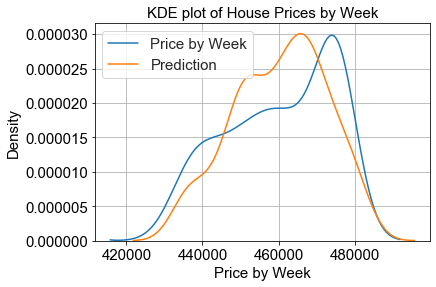

In [31]:
#Kernel Density Estimation Plots (to take a look at the Distribution for each of the variables)
import seaborn as sns
def kde_plot(a,b,c,d,e):
    fig = plt.figure(figsize=(6,4)) # Define plot area
    ax = fig.gca() # Define axis 
    sns.set_style("whitegrid")
    sns.kdeplot(a, ax = ax, label = c)
    sns.kdeplot(b, ax = ax, label = d)
    ax.set_title('KDE plot of ' + e, fontsize = 15) # Give the plot a main title
    ax.set_xlabel('Price by Week', fontsize = 15) # Set text for the x axis
    ax.set_ylabel('Density', fontsize = 15)# Set text for y axis
    ax.legend(loc='upper left', fontsize=15)
    ax.tick_params(axis="x", labelsize=15)
    ax.tick_params(axis="y", labelsize=15)
    ax.grid(True) 
    
kde_plot(Price,Prediction_price,"Price by Week","Prediction","House Prices by Week")

It is possible to see that even though there are some of the elements of the original data reflected in the predicted data, there is a clear shift and overestimation of the `price` at the center of the distribution.

In [32]:
def plot_hist(x, p=5):
    # Plot the distribution and mark the mean
    plt.hist(x, alpha=.5)
    plt.axvline(x.mean())
    plt.axvline(np.percentile(x, 100-p/2.), color='red', linewidth=3)   
    plt.axvline(np.percentile(x, p/2.), color='red', linewidth=3)
    plt.show()

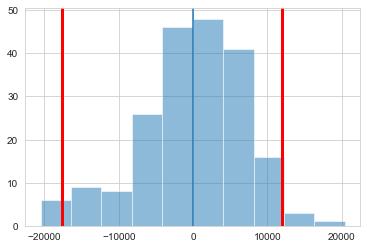

In [33]:
#diffs = pd.Series(diffs)
Delta = Price - Prediction_price
Delta =  pd.Series(Delta)
Delta = Delta.reset_index()
Delta = Delta.iloc[:,1]
#print(Delta)
plot_hist(Delta)

It is possible to see that 95% of the difference between the Prediction and the Actual `price` lies between ~ -18,000/+12,000.

In [34]:
def t_test(a, b, alpha, alternative='two-sided'):
    import statsmodels.stats.weightstats as ws 
    diff = a.mean() - b.mean()
    res = ss.ttest_ind(a, b, equal_var=False)  
    means = ws.CompareMeans(ws.DescrStatsW(a), ws.DescrStatsW(b))
    confint = means.tconfint_diff(alpha=alpha, alternative=alternative, usevar='unequal') 
    degfree = means.dof_satt()
    index = ['DegFreedom', 'Difference', 'Statistic', 'PValue', 'Low95CI', 'High95CI']
    return pd.Series([degfree, diff, res[0], res[1], confint[0], confint[1]], index = index)

In [35]:
Price_log = pd.Series(np.log(house_df['Daily']))
Price_log = Price_log.reset_index(drop=True)

Prediction_price_log = pd.Series(np.log(house_df['scores']))
Prediction_price_log = Prediction_price_log.reset_index(drop=True)

In [36]:
t_test(Prediction_price_log,Price_log,0.05)

DegFreedom    397.043011
Difference      0.000121
Statistic       0.042742
PValue          0.965929
Low95CI        -0.005444
High95CI        0.005686
dtype: float64

From the T Test between both distributions and with an alpha value of 0.05, it is possible to see that we failed to reject the Null Hypothesis that both distributions are similar. Therefore it is possible to believe that both the **Prediction** get us close enough to the actual **Price** values.

### ARIMA Model (extra)

In [37]:
#A new package is available that could replace model_ARIMA_2 method. The method auto_arima is part of pyramid package. 
#The advantages of this package is that it can omit the errors/warning you might face during the iterative process. 
#For more details on how to use the method, please see documentation at https://www.alkaline-ml.com/pyramid/modules/generated/pyramid.arima.auto_arima.html, 
#and example on how to use at https://www.alkaline-ml.com/pyramid/quickstart.html#
#The code below could replace the code in previous cell: #Step ARIMA to find the best ORDER
#price_summary = pd.Series(house_df['Daily'])

from pmdarima.arima import auto_arima
stepwise_fit = auto_arima(price_decom.resid[6:-6], start_p=1, start_q=1,
#stepwise_fit = auto_arima(price_summary, start_p=1, start_q=1,
                             max_p=3, max_q=3, max_P=3, m=24, #m -> the number of observations per cycle
                             start_P=1, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise


stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[24]             : AIC=426.601, Time=2.30 sec
 ARIMA(0,1,0)(0,1,0)[24]             : AIC=441.578, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[24]             : AIC=inf, Time=0.90 sec
 ARIMA(0,1,1)(0,1,1)[24]             : AIC=inf, Time=0.87 sec
 ARIMA(1,1,1)(0,1,1)[24]             : AIC=inf, Time=1.20 sec
 ARIMA(1,1,1)(1,1,0)[24]             : AIC=423.622, Time=1.17 sec
 ARIMA(1,1,1)(0,1,0)[24]             : AIC=431.330, Time=0.09 sec
 ARIMA(1,1,1)(2,1,0)[24]             : AIC=426.814, Time=6.64 sec
 ARIMA(1,1,1)(2,1,1)[24]             : AIC=inf, Time=4.80 sec
 ARIMA(0,1,1)(1,1,0)[24]             : AIC=409.738, Time=0.73 sec
 ARIMA(0,1,1)(0,1,0)[24]             : AIC=429.777, Time=0.05 sec
 ARIMA(0,1,1)(2,1,0)[24]             : AIC=422.194, Time=5.32 sec
 ARIMA(0,1,1)(1,1,1)[24]             : AIC=411.134, Time=2.95 sec
 ARIMA(0,1,1)(2,1,1)[24]             : AIC=inf, Time=2.80 sec
 ARIMA(0,1,0)(1,1,0)[24]             : AIC=inf, Time=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   44
Model:             SARIMAX(2, 1, 3)x(1, 1, [], 24)   Log Likelihood                -197.270
Date:                             Mon, 15 Feb 2021   AIC                            408.541
Time:                                     21:36:53   BIC                            415.152
Sample:                                          0   HQIC                           409.660
                                              - 44                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2718      0.300     -4.238      0.000      -1.860      -0.684
ar.L2         -0.8830      0.238     -3.708      0.000      -1.350      -0.416
ma.L1          0.8576      1.117      0.768      0.443      -1.332       3.047
ma.L2         -0.2777      1.053     -0.264      0.792      -2.342       1.786
ma.L3         -0.5625      0.809     -0.696      0.487      -2.147       1.022
ar.S.L24      -1.0000      0.114     -8.766      0.000      -1.224      -0.776
sigma2      8.824e+07   8.92e-09   9.89e+15      0.000    8.82e+07    8.82e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 0.70
Prob(Q):                              0.72   Prob(JB):                         0.71
Heteroskedasticity (H):               0.86   Skew:                            -0.37
Prob(H) (two-sided):                  0.86   Kurtosis:                         2.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.45e+33. Standard errors may be unstable.
"""

In [38]:
house_df.loc[:, 'ARIMA_scores'] =  stepwise_fit.predict(n_periods = house_df.Daily.shape[0])

In [39]:
house_df.loc[:, 'Final'] = house_df.loc[:, 'ARIMA_scores'] + house_df.loc[:, 'scores']
def plot_mod_fit_temp(df, col):
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(8, 5)) # set plot area
    ax = fig.gca() # define axis  
    df.loc[:, col].plot(color = 'r', ax = ax)
    df.loc[:, 'Final'].plot(ax = ax) 
    ax.set_title('Actual ' + col + ' vs. the predicted values', fontsize = 15) # Give the plot a main title
    ax.set_xlabel('Date',fontsize = 15) # Set text for the x axis
    ax.set_ylabel(col,fontsize = 15)# Set text for y axis
    ax.grid(True)

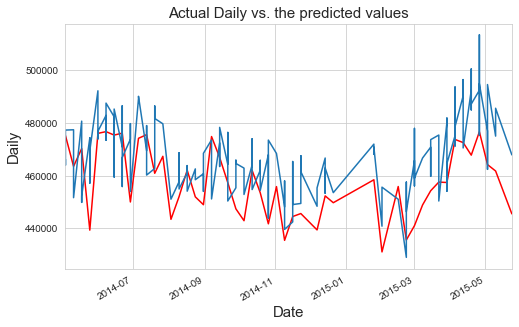

In [40]:
plot_mod_fit_temp(house_df, 'Daily') 

# Conclusions/Summary:

Quick re-cap of the analysis above:

- The dataframe in this analysis contains data for 1 year of houses' prices at King County (2014 - 2015), where there are multiple entries in one day and non in others adding another layer of complexity to the analysis.

- For practical reasons the `price` variable was group by week.

- The Time Series for the `price` variable was found **STATIONARY** as the variation of the residual values do not grow over time (after grouped by week).

- In the case of the `price` variable which was analyzed in here, there is a strong trend effect. Note: This trend effect it is something that should be explored once more data is acquired to confirm that during winter (around Jan) home prices really decrease, if that is the case then this is not a trend but a seasonal effect hidden by the lack of data in this analysis.

- The STL decomposition of the time series was performed with the additive model. This since the Residuals for the variable analyzed (`price`) was found **STATIONARY**.

- At this moment the main model was a linear regression model for the Time Series.


Regarding the Predictions:

- As saw in the plot above the *predictions* do a good job following the trend of the `price` values.
    - It is possible to see that the Regression Model follows the general trend of the `price` Time Series, but even though it is a great guideline regarding the behavior of the `price` variable in time, it fails to provide a more meaningful and precise prediction of the data. Also it is possible to see that some overfitting might be happening as only 1 year it is represented here (2014 - 2015).

- From the T Test between both distributions and with an alpha value of 0.05, it is possible to see that we failed to reject the Null Hypothesis that both distributions are similar. Therefore it is possible to believe that both the **Prediction** get us close enough to the actual **Price** values.